In [243]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import time
import math

# Mise en place du problème : création du maillage et du condensateur, ajout des conditions aux limites...

### CONDITIONS DE DIRICHLET


In [244]:
# On utilisera les données du fichier poisson.pdf

# Condtions de Dirichlet aux bords
uG,uD,uH,uB = 0,0,0,0 #gauche, droite, haut, bas

# Condtions de Dirichlet dans l'espace 
eps0 = 8.85e-12
uNeg,uPos = -1/eps0, 1/eps0

### CONSTRUCTION DU MAILLAGE ET DU CONDENSATEUR 


In [245]:
# Construction du maillage #
I,J = 65,65
delta_x=1/I
delta_y=1/J
x,y = np.linspace(0,1,I),np.linspace(0,1,J)
dx,dy = x[1]-x[0],y[1]-y[0] #Pas

X,Y = np.meshgrid(x,y) #Création du tableau maillage
X_1D,Y_1D = X.ravel(), Y.ravel() #Passage de 2D à 1D

# Construction du condensateur
x_cond = [0.25,0.75]
y1,y2 = int(0.4/dy), int(0.6/dy)

y_cond_pos =y1*dy 
y_cond_neg = y2*dy

L_pos=np.squeeze(np.where((X_1D>x_cond[0]) & (X_1D<x_cond[1]) & (Y_1D==y_cond_pos)))
L_pos_reel=np.where((X>x_cond[0]) & (X<x_cond[1]) & (Y==y_cond_pos))

L_neg=np.squeeze(np.where((X_1D>x_cond[0]) & (X_1D<x_cond[1]) & (Y_1D==y_cond_neg)))
L_neg_reel=np.where((X>x_cond[0]) & (X<x_cond[1]) & (Y==y_cond_neg))

In [246]:
# Indices maillage
ind_bords = np.squeeze(np.where((X_1D==x[0]) | (X_1D==x[I-1]) | (Y_1D==y[0]) | (Y_1D==y[J-1])))
ind_bords_reel = np.where((X==x[0])|(X==x[I-1])|(Y==y[0])|(Y==y[J-1]))

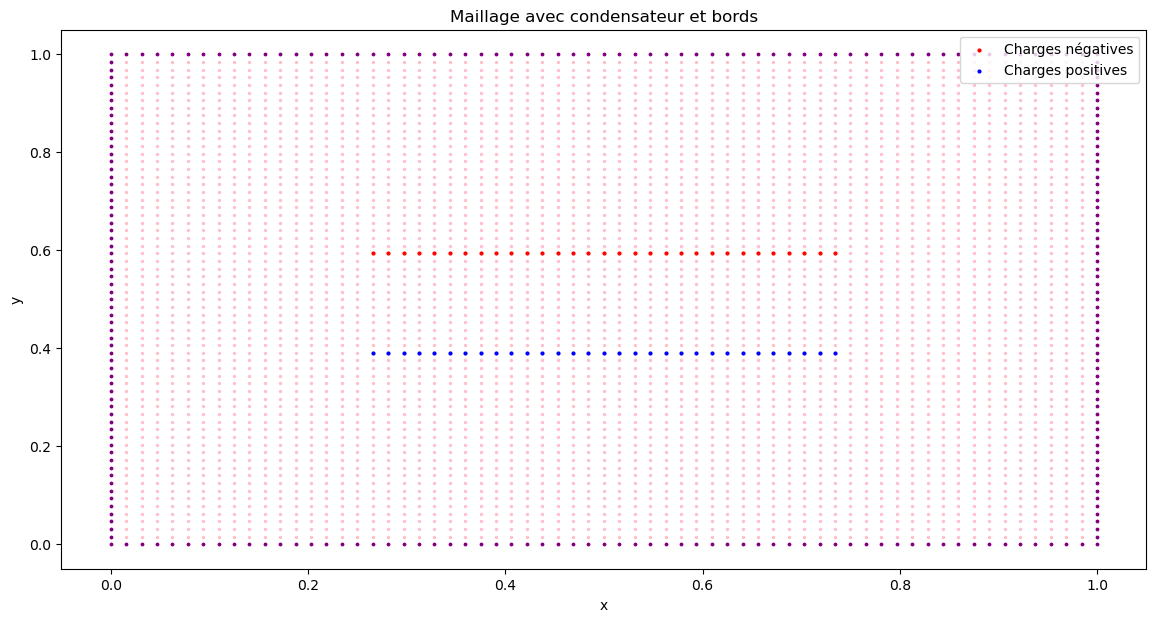

In [266]:
## AFFICHAGE DU MAILLAGE ## 
plt.figure(figsize = (14,7))
plt.scatter(X,Y,2,color = 'pink')
plt.scatter(X[ind_bords_reel],Y[ind_bords_reel],3,color='purple')
plt.scatter(X[L_neg_reel],Y[L_neg_reel],4,label="Charges négatives",color='red')
plt.scatter(X[L_pos_reel],Y[L_pos_reel],4,label="Charges positives",color='blue')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Maillage avec condensateur et bords")
plt.legend(loc='upper right')
plt.show()

In [248]:
s = np.zeros(I*J)

# indices des bords
ind_bord_gauche = np.squeeze(np.where(X_1D==x[0]))
ind_bord_droite = np.squeeze(np.where(X_1D==x[I-1]))
ind_bord_bas = np.squeeze(np.where(Y_1D==y[0]))
ind_bord_haut = np.squeeze(np.where(Y_1D==y[J-1]))

# Conditions aux limites
s[ind_bord_gauche] = uG # gauche
s[ind_bord_droite] = uD # droite
s[ind_bord_bas] = uB # bas
s[ind_bord_haut] = uH # haut

# Charges positives et négatives
s[L_pos] = uPos
s[L_neg] = uNeg

len(s)

4225

In [249]:
I2=1/(delta_x)**2
J2=1/(delta_y)**2

Diag=sp.eye(I*J)*(-2*(I2+J2))


diago_inf=([J2]*(J-1)+[0])*(I-1)+[J2]*(J-1)
T_Inf=sp.diags([[I2]*(J**2-J), diago_inf],[-J,-1]) #Triangulaire inférieure

diago_sup=[J2]*(J-2)+[0]+([J2]*(J-1)+[0])*(I-3)+[I2]*(2*J)
T_Sup=sp.diags([[I2]*(I**2-I),diago_sup],[I,1]) #Triangulaire supérieure le coefficient 1 permet de ne pas prendre la diagonale

M=Diag+T_Sup+T_Inf

# Résolution de l'équation de Poisson avec différentes méthodes 

##  1) Méthode de la matrice creuse "Sparce"

In [250]:
## FONCTIONS DERIVEES ##

# Calcul des dérivées partielles de l'équation de Poisson en utilisant la méthode sparse. 
# Initialement, nous travaillons sur une seule dimension avant de l'étendre à 2D sur la grille. 
# Dans cette approche, étant donné que nous traitons des matrices majoritairement composées de zéros, nous utilisons la méthode sparse qui consiste à remplir les matrices uniquement aux emplacements où les éléments sont non nuls. 
# Il est important de noter que si la matrice n'est pas principalement constituée de zéros, cette méthode peut être inefficace, car elle remplit un par un les éléments de la matrice. 
# Cependant, dans notre cas, où nous manipulons des matrices creuses, cette méthode offre une solution plus efficace.

def Derive1D(Nx):
    # Première dérivée
    D_1d = sp.diags([-1, 1], [-1, 1], shape = (Nx,Nx)) # on doit diviser par le pas au carré mais je le ferai à la fin 
    D_1d = sp.lil_matrix(D_1d)                  # Ici on crée la matrice de diag nul, la diag supérieur a celle centrale qui vaut que des 1 et celle d'en dessous qui vaut que des -1 
    D_1d[0,[0,1,2]] = [1, -4, 1]               # on créer la première dérivée en accord avec la formule de Taylor
    D_1d[Nx-1,[Nx-3, Nx-2, Nx-1]] = [1, -4, 1]  
    # Seconde dérivée
    D2_1d =  sp.diags([1, -2, 1], [-1,0,1], shape = (Nx, Nx)) # on doit diviser par le pas au carré mais je le ferai à la fin
    D2_1d = sp.lil_matrix(D2_1d)                  
    D2_1d[0,[0,1,2,3]] = [1, 1, -4, 1]                    
    D2_1d[Nx-1,[Nx-4, Nx-3, Nx-2, Nx-1]] = [1, -4, 1, 1]  
    return D_1d, D2_1d


def Derive2D(Nx,Ny):
    Dx_1d, D2x_1d = Derive1D(Nx) #on récupère les premières dérivées 1D à la bonne dimension 
    Dy_1d, D2y_1d = Derive1D(Ny)
    # matrice identité sparse
    Ix = sp.eye(Nx)
    Iy = sp.eye(Ny)
    # utilisation du produit de kronecker avec l'identité sparse pour la fabriquation de la matrice du système comprenant les deux dérivées partielles
    # Première dérivée partielle
    Dx_2d = sp.kron(Iy,Dx_1d)
    Dy_2d = sp.kron(Dy_1d,Ix)
    # deuxième dérivée partielle
    D2x_2d = sp.kron(Iy,D2x_1d)
    D2y_2d = sp.kron(D2y_1d,Ix)
    return Dx_2d.tocsr(), Dy_2d.tocsr(), D2x_2d.tocsr(), D2y_2d.tocsr()  #format de la sparse matrice

In [251]:
def solve_sparse(I, J, dx, dy, ind_bords,s):
    start_time = time.time()

    # Initialisation des matrices de dérivées secondes 2D
    Dx_2d, Dy_2d, D2x_2d, D2y_2d = Derive2D(I, J)
    
    # Matrice identité
    I_sp = sp.eye(I*J).tocsr()
    
    # Construction du système sans les conditions aux limites
    L = D2x_2d / dx**2 + D2y_2d / dy**2
    
    # Ajout des conditions aux limites
    L[ind_bords, :] = I_sp[ind_bords, :]

    # Résolution du système
    X_sparse = spsolve(L,s).reshape(I, J)
    
    end_time = time.time()
    temps_sparse = end_time - start_time

    return X_sparse, temps_sparse

X_sparse,temps_sparse = solve_sparse(I, J, dx, dy, ind_bords,s)

Le temps d'exécution de la méthode sparse est 0.022028446197509766


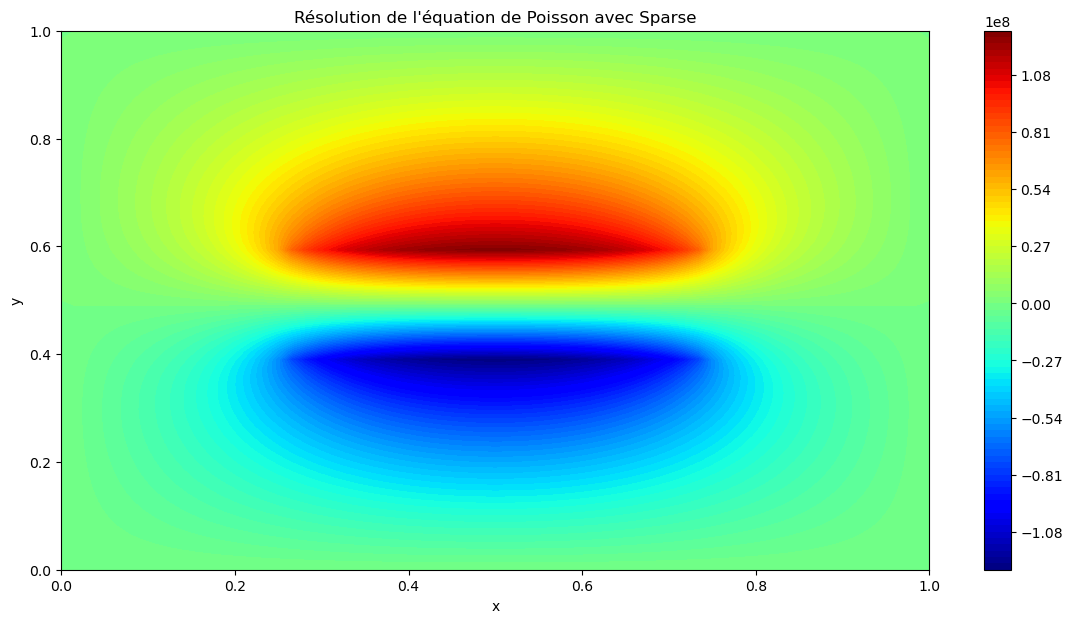

In [252]:
print("Le temps d'exécution de la méthode sparse est",temps_sparse)
# Affichage de la solution
plt.figure(figsize = (14,7))
plt.contourf(X, Y,X_sparse, 100,cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec Sparse")
plt.show()

##  2) Méthode de spsolve du module scipy.sparse.linalg

In [253]:
# Résolution de l'équation avec linalg.solve du module numpy 

start_time = time.time()
X_linalg = spsolve(M,s).reshape(I,J)
end_time = time.time()

temps_spsolve = end_time - start_time

Le temps d'exécution de la méthode linalg.solve est 0.011191606521606445


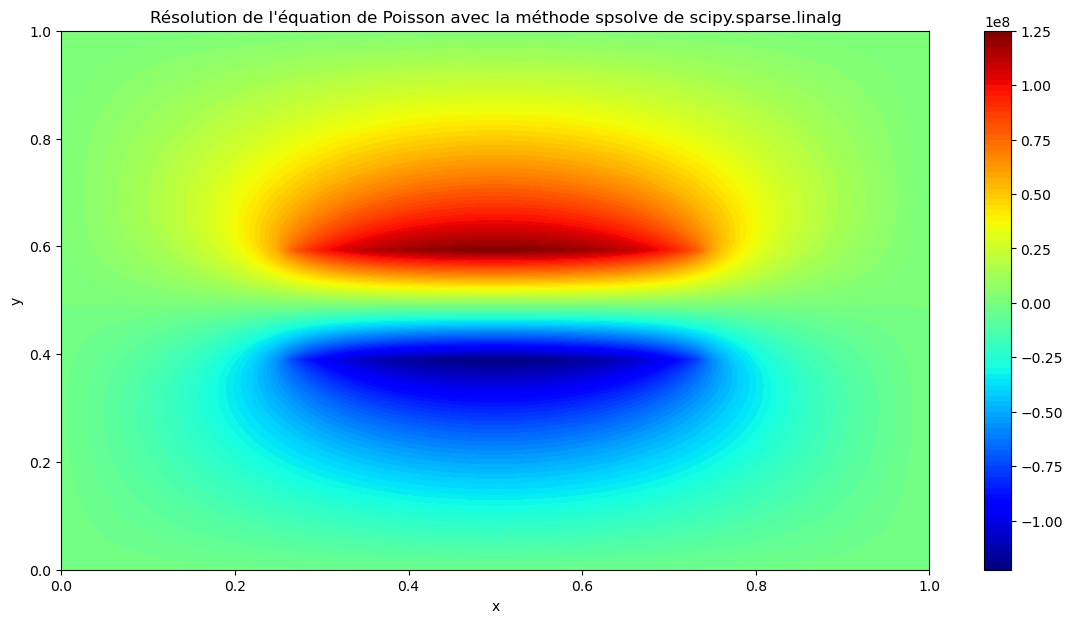

In [254]:
print("Le temps d'exécution de la méthode linalg.solve est",temps_spsolve)

# Affichage de la solution
plt.figure(figsize = (14,7))
plt.contourf(X, Y, X_linalg,100,cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec la méthode spsolve de scipy.sparse.linalg")
plt.show()

##  3) Méthode de Jacobi matricielle

In [255]:
#Résolution par la méthode de Jacobi matricielle

#Il faut décomposer la matrice des coefficients en somme de matrice diagonale, triangulaire supérieure et triangulaire inférieur:
#M=D+TS+TI
e = 0.0001  # Critère d'arrêt de l'itération
X_JacobiM0 = np.zeros(I * J)  # Initialisation du vecteur potentiel
X_JacobiM = np.ones(I * J)
c = 0  # Compteur d'itérations

# Précalcul des coefficients constants
inv_denom = 1 / (2 * (I2 + J2))

start_time = time.time()

M_inv = inv_denom * (TS + TI) # Matrice de préconditionnement

while np.linalg.norm(X_JacobiM - X_JacobiM0) >= e * np.linalg.norm(X_JacobiM0):
    X_JacobiM0[:] = X_JacobiM
    X_JacobiM = M_inv @ X_JacobiM - inv_denom * s
    c += 1

X_JacobiM = X_JacobiM.reshape((I, J))

end_time = time.time()

print(c)
temps_Jacobi_mat = end_time - start_time

1150


Le temps d'exécution de la méthode parJacobi matricielle est 0.038340091705322266


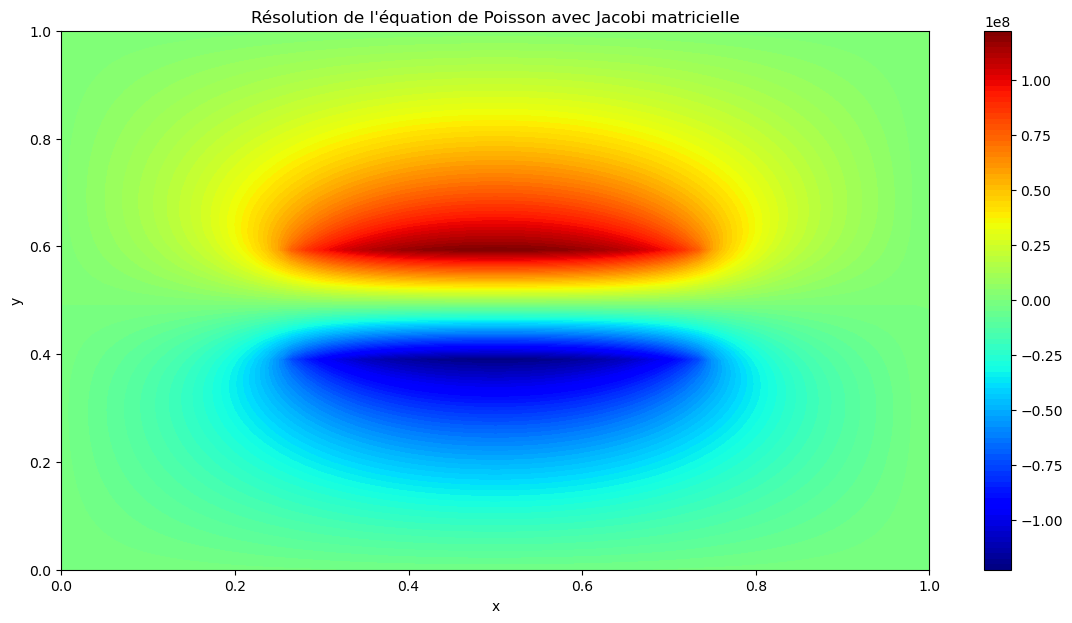

In [256]:
print("Le temps d'exécution de la méthode parJacobi matricielle est",temps_Jacobi_mat)


# Affichage de la solution
plt.figure(figsize = (14,7))
plt.contourf(X, Y, X_JacobiM,100, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec Jacobi matricielle")
plt.show()

##  4) Méthode de Jacobi coefficient par coefficient

In [257]:
X_Jacobi = np.ones(I * J)
c = 0  # Compteur d'itérations
max_ite = 10**4

start_time = time.time()

while c <= max_ite:
    sauvegarde = X_Jacobi.copy()  # On garde en mémoire la matrice de l'itération k pour l'utiliser à l'itération k+1

    for i in range(I * J):
        c1, c2, c3, c4 = 0, 0, 0, 0  # Initialisation des coefficients

        if i % J != 0:  # Pas sur la première colonne
            c1 = J2 * sauvegarde[i - I]

        if i // J > 0:  # Pas sur la première ligne
            c2 = I2 * sauvegarde[i - 1]

        if i % J < J - 1:  # Pas sur la dernière colonne
            c3 = J2 * sauvegarde[i + 1]

        if i // J < I - 1:  # Pas sur la dernière ligne
            c4 = I2 * sauvegarde[i + I]

        if i % J == 0 and i // J <= J - 1:  # Dirichlet sur la première colonne
            c2 = 0

        if (i - (J - 1) % J == 0) and (i - (J - 1) // J <= (I - 1)):  # Dirichlet sur la dernière colonne
            c3 = 0

        X_Jacobi[i] = 1 / (2 * (I2 + J2)) * (c1 + c2 + c3 + c4 - s[i])

    c += 1

X_Jacobi = X_Jacobi.reshape((I, J))

end_time = time.time()

temps_Jacobi = end_time - start_time
print("Le temps d'exécution de la méthode de Jacobi est", temps_Jacobi)


Le temps d'exécution de la méthode de Jacobi est 65.00043082237244


Le temps d'exécution de la méthode parJacobi coeff par coeff est 65.00043082237244


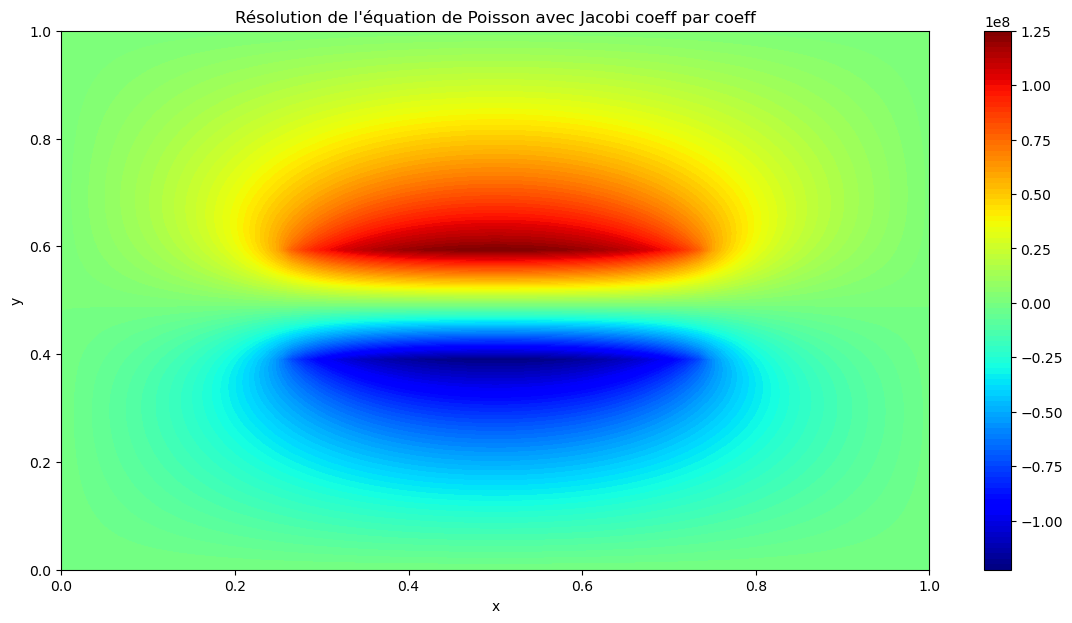

In [258]:
print("Le temps d'exécution de la méthode parJacobi coeff par coeff est",temps_Jacobi)

# Affichage de la solution
plt.figure(figsize = (14,7))
plt.contourf(X, Y, X_Jacobi,100, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec Jacobi coeff par coeff")
plt.show()

##  5) Méthode de Gauss-Seidel matricielle

In [259]:
epsilon = 10**(-4)  # Critère d'arrêt de l'itération
X_GS_mat0 = np.zeros(I * J)  # Initialisation du vecteur potentiel
X_GS_mat = np.ones(I * J)
c_GS_mat = 0

start_time = time.time()
inv_sum = np.linalg.inv(TI.toarray() + D.toarray())

while np.linalg.norm(X_GS_mat - X_GS_mat0) >= epsilon * np.linalg.norm(X_GS_mat0):
    sauvegarde = X_GS_mat.copy()
    X_GS_mat = X_GS_mat - inv_sum @ (Matrice @ X_GS_mat - s)

    X_GS_mat0 = sauvegarde
    c_GS_mat += 1

X_GS_mat = X_GS_mat.reshape((I, J))

end_time = time.time()

print(c_GS_mat)
temps_GS_mat = end_time - start_time

691


Le temps d'exécution de la méthode par Gauss-Seidel matricielle est 6.932325839996338


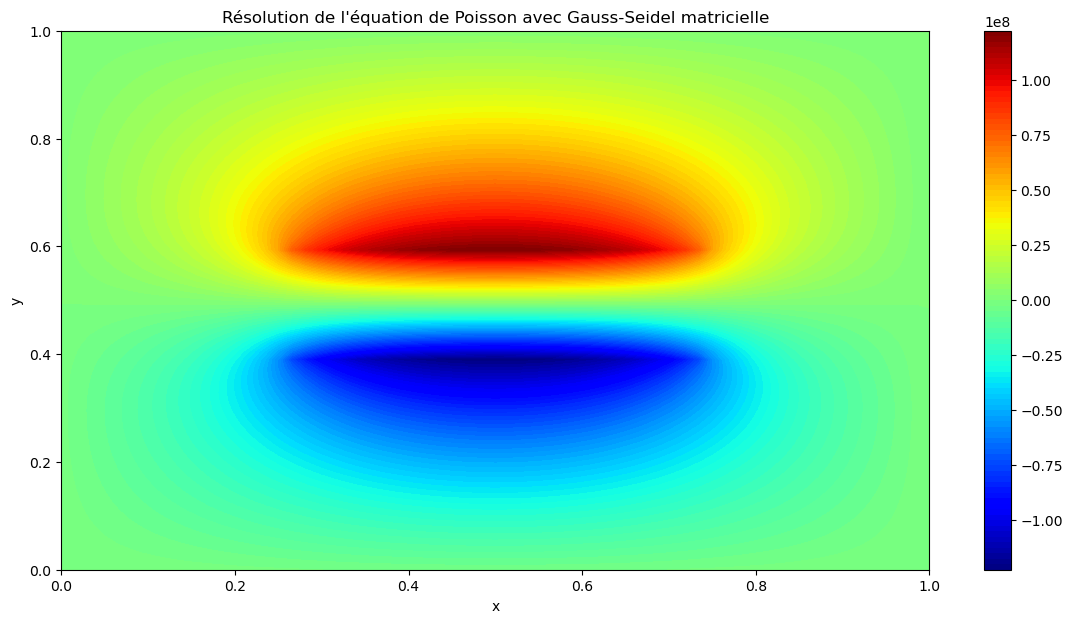

In [260]:
print("Le temps d'exécution de la méthode par Gauss-Seidel matricielle est",temps_GS_mat)

# Affichage de la solution
plt.figure(figsize = (14,7))
plt.contourf(X, Y, X_GS_mat,100, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec Gauss-Seidel matricielle")
plt.show()

##  6) Méthode de Gauss-Seidel coefficient par coefficient

In [261]:
#Résolution par la méthode de Gauss-Seidel coefficient par coefficient
max_iterations = 10**4
c = 0
X_GS = np.ones(I*J)
start_time = time.time()

while c <= max_iterations:
    for i in range(I*J):
        c1, c2, c3, c4 = 0, 0, 0, 0

        if i == 0:
            c3 = J**2 * X_GS[i+1]
            c4 = I**2 * X_GS[i+I]
            if (i - (J-1) % J == 0) and (i - (J-1) // J <= (I-1)):
                c3 = 0

        elif (0 < i < J):
            c2 = J**2 * X_GS[i-1]
            c3 = J**2 * X_GS[i+1]
            c4 = I**2 * X_GS[i+I]
            if (i % J == 0) and (i // J <= J-1):
                c2 = 0
            elif (i - (J-1) % J == 0) and (i - (J-1) // J <= (I-1)):
                c3 = 0

        elif (J <= i < I*(J-1)-1):
            c1 = I**2 * X_GS[i-I]
            c2 = J**2 * X_GS[i-1]
            c3 = J**2 * X_GS[i+1]
            c4 = I**2 * X_GS[i+I]
            if (i % J == 0) and (i // J <= J-1):
                c2 = 0
            elif (i - (J-1) % J == 0) and (i - (J-1) // J <= (I-1)):
                c3 = 0

        elif (I*(J-1)-1 <= i < I*J-1):
            c1 = I**2 * X_GS[i-I]
            c2 = J**2 * X_GS[i-1]
            c3 = J**2 * X_GS[i+1]
            if (i % J == 0) and (i // J <= (J-1)):
                c2 = 0
            elif (i - (J-1) % J == 0) and (i - (J-1) // J <= (I-1)):
                c3 = 0

        elif i == I*J-1:
            c1 = I**2 * X_GS[i-I]
            c2 = J**2 * X_GS[i-1]
            if (i % J == 0) and (i // J <= (J-1)):
                c2 = 0

        S = c1 + c2 + c3 + c4
        X_GS[i] = 1 / (2 * (I**2 + J**2)) * (S - s[i])

    c += 1

X_GS = X_GS.reshape((I, J))
end_time = time.time()
temps_GS = end_time - start_time

Le temps d'exécution de la méthode parJacobi coeff par coeff est 75.73681950569153


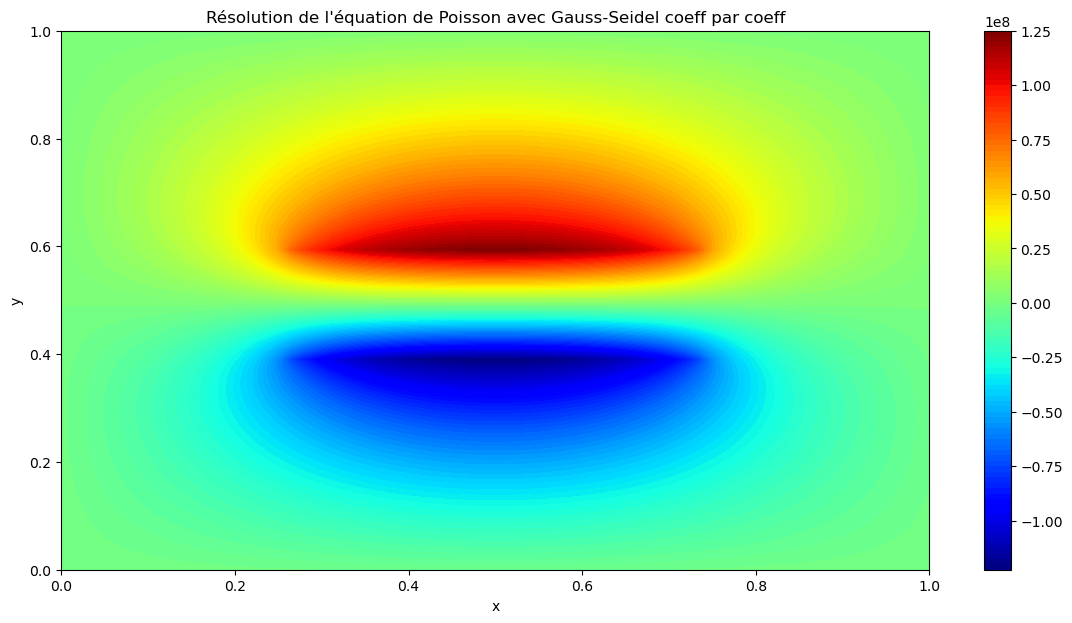

In [262]:
print("Le temps d'exécution de la méthode parJacobi coeff par coeff est",temps_GS)

# Affichage de la solution
plt.figure(figsize = (14,7))
plt.contourf(X, Y, X_GS,100, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec Gauss-Seidel coeff par coeff")
plt.show()

##  7) Méthode de sur-relaxation

In [263]:
#Résolution par la méthode de sur-relaxation
omega = 2 / (1 + np.sin(np.pi * dx))  # w optimal pour l'équation de Poisson avec des conditions de Dirichlet, w=1 pour Gauss-Seidel
eps = 1e-10
max_iterations = 1000  # Critère d'arrêt de l'itération

c = 0  # Initialisation compteur
X_SR = np.ones(I*J)  # Initialisation du vecteur potentiel

start_time = time.time()

while c <= max_iterations:
    for i in range(I*J):
        c1, c2, c3, c4 = 0, 0, 0, 0

        if i == 0:
            c3 = J**2 * X_SR[i+1]
            c4 = I**2 * X_SR[i+I]
            if (i - (J-1) % J == 0) and (i - (J-1) // J <= (I-1)):
                c3 = 0

        elif (0 < i < J):
            c2 = J**2 * X_SR[i-1]
            c3 = J**2 * X_SR[i+1]
            c4 = I**2 * X_SR[i+I]
            if (i % J == 0) and (i // J <= J-1):
                c2 = 0
            elif (i - (J-1) % J == 0) and (i - (J-1) // J <= (I-1)):
                c3 = 0

        elif (J <= i < I*(J-1)-1):
            c1 = I**2 * X_SR[i-I]
            c2 = J**2 * X_SR[i-1]
            c3 = J**2 * X_SR[i+1]
            c4 = I**2 * X_SR[i+I]
            if (i % J == 0) and (i // J <= J-1):
                c2 = 0
            elif (i - (J-1) % J == 0) and (i - (J-1) // J <= (I-1)):
                c3 = 0

        elif (I*(J-1)-1 <= i < I*J-1):
            c1 = I**2 * X_SR[i-I]
            c2 = J**2 * X_SR[i-1]
            c3 = J**2 * X_SR[i+1]
            c4 = 0
            if (i % J == 0) and (i // J <= (J-1)):
                c2 = 0
            elif (i - (J-1) % J == 0) and (i - (J-1) // J <= (I-1)):
                c3 = 0

        elif i == I*J-1:
            c1 = I**2 * X_SR[i-I]
            c2 = J**2 * X_SR[i-1]
            if (i % J == 0) and (i // J <= (J-1)):
                c2 = 0

        S_SR = c1 + c2 + c3 + c4
        X_SR[i] = (1 - omega) * X_SR[i] + omega / (2 * (I**2 + J**2)) * (S_SR - s[i])

    c += 1

X_SR = X_SR.reshape((I, J))

end_time = time.time()

temps_SR = end_time - start_time


Le temps d'exécution de la méthode par sur-relaxation est 8.629708766937256


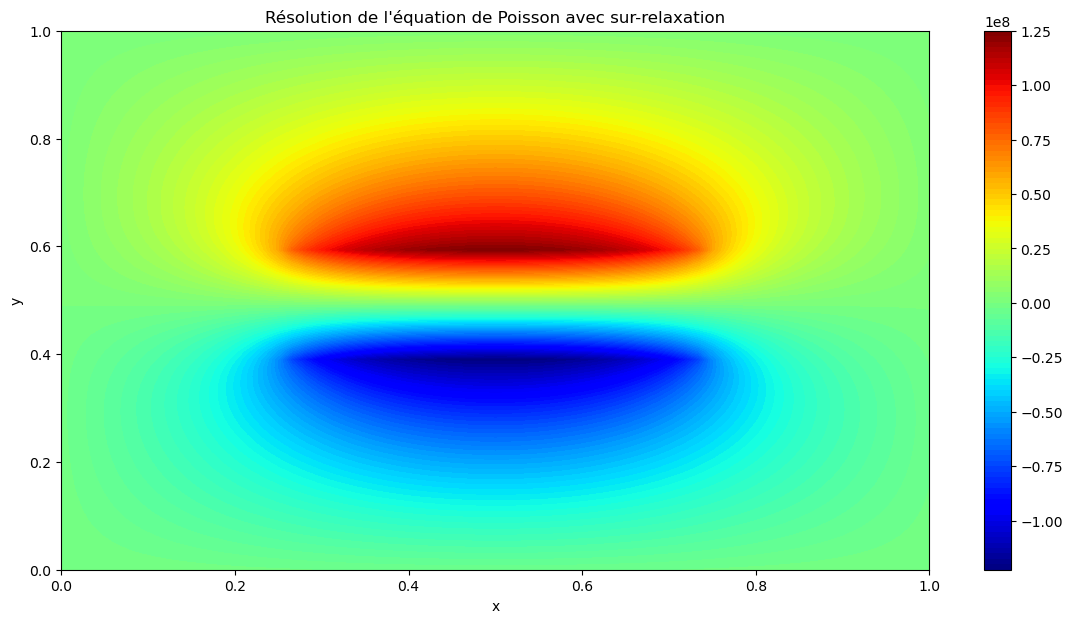

In [264]:
print("Le temps d'exécution de la méthode par sur-relaxation est",temps_SR)


# Affichage de la solution
plt.figure(figsize = (14,7))
plt.contourf(X, Y, X_SR,100, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec sur-relaxation")
plt.show()

# Comparaison des différentes méthodes

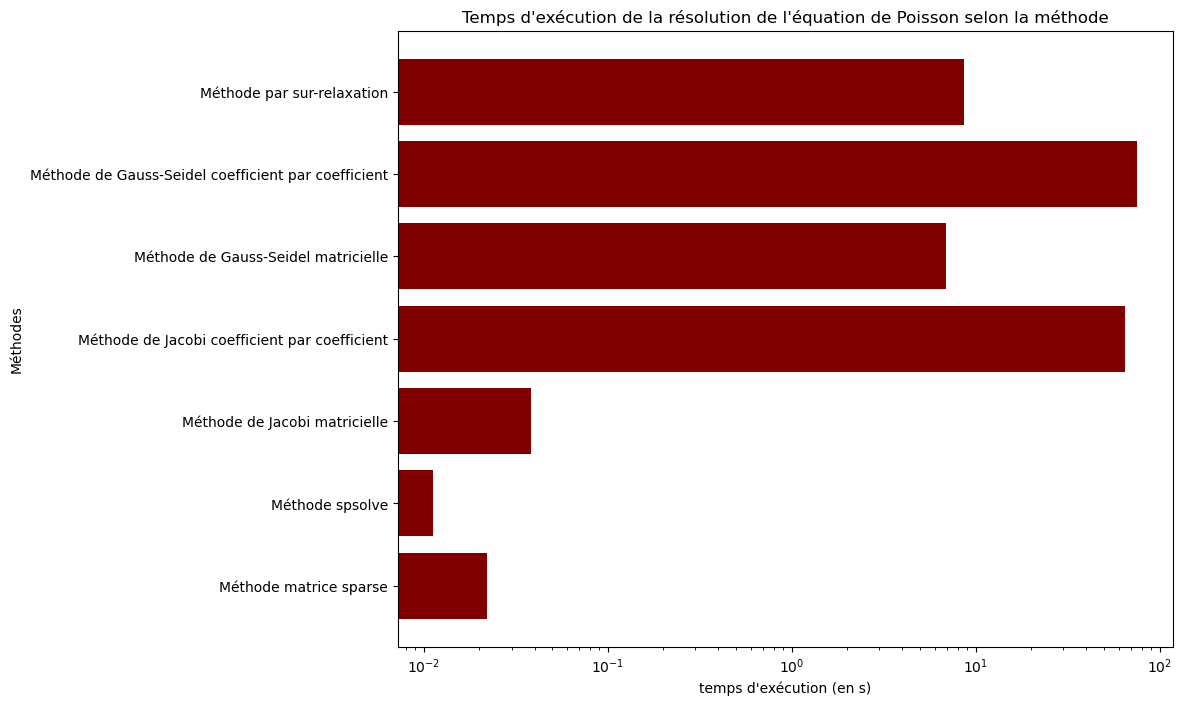

In [265]:
temps=[temps_sparse, temps_spsolve, temps_Jacobi_mat, temps_Jacobi, temps_GS_mat, temps_GS, temps_SR]
methodes=["Méthode matrice sparse","Méthode spsolve", "Méthode de Jacobi matricielle", "Méthode de Jacobi coefficient par coefficient", "Méthode de Gauss-Seidel matricielle", "Méthode de Gauss-Seidel coefficient par coefficient", "Méthode par sur-relaxation"]
plt.figure(figsize = (10,8))
plt.barh(methodes,temps, log=True, color='maroon')
plt.xlabel("temps d'exécution (en s)")
plt.ylabel('Méthodes')
plt.title("Temps d'exécution de la résolution de l'équation de Poisson selon la méthode")
plt.show()